## EDA notebook

### Group 8 Members
#### Spring Semester 2024-2025
- Alexandre Gonçalves - 20240738
- Bráulio Damba - 20240007
- Hugo Fonseca - 20240520
- Ricardo Pereira - 20240745
- Victoria Goon - 20240550

### 1 - Imports

In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import nltk 
from nltk.corpus import stopwords
from wordcloud import WordCloud 
from collections import Counter 
from sklearn.feature_extraction.text import CountVectorizer 

import emoji 
import matplotlib.font_manager as fm 


# Set pd options to display all columns and rows
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 30)
pd.set_option("display.max_colwidth", 5000)

In [2]:
# Define the base directory (where the notebook is)
BASE_DIR = os.path.dirname(os.path.abspath("__file__"))

# Construct full paths to the CSV files in the data folder i.e. "/data/train"
train_path = os.path.join(BASE_DIR, "data", "train.csv")
test_path = os.path.join(BASE_DIR, "data", "test.csv")

# Load the datasets
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

### 2 - First overview of the training dataset 

In [3]:
print("Train Shape: " + str(df_train.shape))
print("Test Shape: " + str(df_test.shape))

Train Shape: (9543, 2)
Test Shape: (2388, 2)


In [4]:
df_train.head(5)

,text,label
0,$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT,0
1,$CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean https://t.co/yGjpT2ReD3,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan on weak building outlook https://t.co/KN1g4AWFIb",0
3,$ESS: BTIG Research cuts to Neutral https://t.co/MCyfTsXc2N,0
4,$FNKO - Funko slides after Piper Jaffray PT cut https://t.co/z37IJmCQzB,0


No nulls or nans

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9543 entries, 0 to 9542
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9543 non-null   object
 1   label   9543 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.2+ KB


In [6]:
df_train.isnull().sum()

text     0
label    0
dtype: int64

Make a copy of the train data to perserve original training data

In [7]:
df_train_copy = df_train.copy()

### 2.1. - Target variable

Each tweet can have one of the following labels: Bearish (0), Bullish (1), or Neutral (2).

Source: Project Handout

In [8]:
label_names = {
    0: 'Bearish',
    1: 'Bullish',
    2: 'Neutral'
}

Tweet count per sentiment label:
label
0    1442
1    1923
2    6178
Name: count, dtype: int64


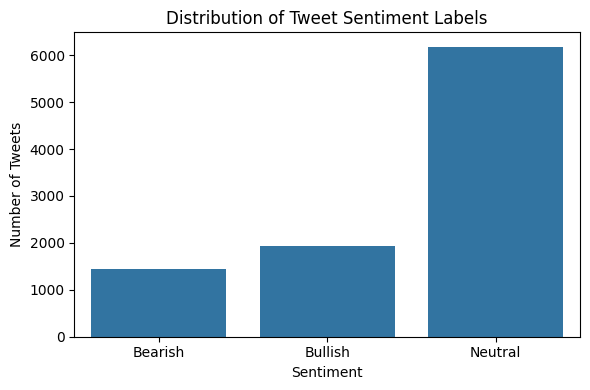

In [9]:
label_counts = df_train['label'].value_counts().sort_index()

print("Tweet count per sentiment label:")
print(label_counts)

label_names = {0: "Bearish", 1: "Bullish", 2: "Neutral"}
labels = [label_names[i] for i in label_counts.index]

plt.figure(figsize=(6, 4))
sns.barplot(x=labels, y=label_counts.values)

plt.title("Distribution of Tweet Sentiment Labels")
plt.ylabel("Number of Tweets")
plt.xlabel("Sentiment")
plt.tight_layout()
plt.show()

In [10]:
class_distribution = df_train['label'].value_counts(normalize=True) * 100
class_distribution = class_distribution.rename(index=label_names)
class_distribution = class_distribution.round(2).astype(str) + '%'
print(class_distribution)

label
Neutral    64.74%
Bullish    20.15%
Bearish    15.11%
Name: proportion, dtype: object


As we have a highly imbalanced dataset, even a bad model can look accurate, so that's why accuracy here is not a good metric.<br/>We will use F1 Macro Average.

### 2.2. - Most frequent Tokens (in absolute value)

In [11]:
def word_counter(text_list):
    """
        Returns absolute frequency of each word in a list of strings.
    """
    words = ' '.join(text_list).split()
    freq = pd.Series(words).value_counts()
    return freq

The top 30 more frequent are predominately stop words 

In [12]:
# Top 30 most common words in the training set
top_30_tokens = word_counter(df_train['text'].tolist())[:30]
print(top_30_tokens)

to                 2332
the                1820
of                 1464
-                  1390
in                 1361
on                 1136
for                1032
a                   970
and                 898
The                 663
at                  539
as                  528
is                  526
by                  414
up                  388
after               379
:                   369
from                347
with                342
U.S.                341
A                   341
Is                  334
#Stock              316
#MarketScreener     284
To                  278
stock               272
Stock               272
more                272
2019                256
are                 246
Name: count, dtype: int64


The top 25 least common words include a mix of rare terms, brand names, and URLs

In [13]:
# Top 25 least common words in the training set
least_25_tokens = word_counter(df_train['text'].tolist())[-25:]
print(least_25_tokens)

surrounding                1
https://t.co/aMleU6pUld    1
conductors                 1
https://t.co/AkPhHv1CI0    1
railyard                   1
Ends?                      1
https://t.co/8d8gjmTbR2    1
https://t.co/G4ks6dZU8O    1
https://t.co/Xmu5o6jOYd    1
"terrible"                 1
Defensive                  1
Supreme:                   1
Reigns                     1
Overstock                  1
Tupperware,                1
Names:                     1
Lows”                      1
“New                       1
Unhappy                    1
https://t.co/aw02S6u7Io    1
https://t.co/SnBOfWESuP    1
underlying                 1
https://t.co/evd7GQxQDr    1
operators                  1
OESX                       1
Name: count, dtype: int64


Links represent 16.04% of the unique words in the training set, indicating that URLs make up a significant portion of the vocabulary.

In [14]:
total_word_count = word_counter(df_train['text'].tolist())
total_words = len(total_word_count)
number_of_links = 0
for word, count in total_word_count.items():
    if 'https://' in word:
        number_of_links+=1
percent_of_links = (number_of_links / total_words) * 100
print("Total number of unique links " + str(number_of_links) + " out of " + str(total_words) + " total unique words.")
print(str(round(percent_of_links,2)) + "% of the training set words are links.")

Total number of unique links 5071 out of 31609 total unique words.
16.04% of the training set words are links.


We found 357 contractions that aren’t typical stopwords, most of them are possessive forms like company names or people’s names

In [15]:
# Words with contractions but that are not part of the stop_words

# Get all sentences with contractions
contraction_sentences = df_train[df_train['text'].str.contains(r"\s\w+'\w+")]['text'].values

# Extract all contractions from those sentences
contractions = []
for sentence in contraction_sentences:
    contractions.extend(re.findall(r"\s(\w+'\w+)", sentence))  

# Clean and filter out standard stopwords
stop_words = set(stopwords.words("english"))
filtered_contractions = [w.lower().strip() for w in set(contractions) if w.lower().strip() not in stop_words]

print("Total contractions: " + str(len(filtered_contractions)))
filtered_contractions[:25]

Total contractions: 357


["amd's",
 "wuhan's",
 "government's",
 "brazil's",
 "supplier's",
 "john's",
 "could've",
 "tuesday's",
 "unisys's",
 "emirate's",
 "malaysia's",
 "wednesday's",
 "etf's",
 "lowe's",
 "health's",
 "bloomberg's",
 "that's",
 "se's",
 "gamesa's",
 "hampshire's",
 "hut's",
 "toyota's",
 "tenb's",
 "alphabet's",
 "biologics's"]

### 2.2. - Tweet Length Analysis 

In [16]:
df_train_copy['char_count'] = df_train['text'].apply(len)
df_train_copy['word_count'] = df_train['text'].apply(lambda x: len(x.split()))

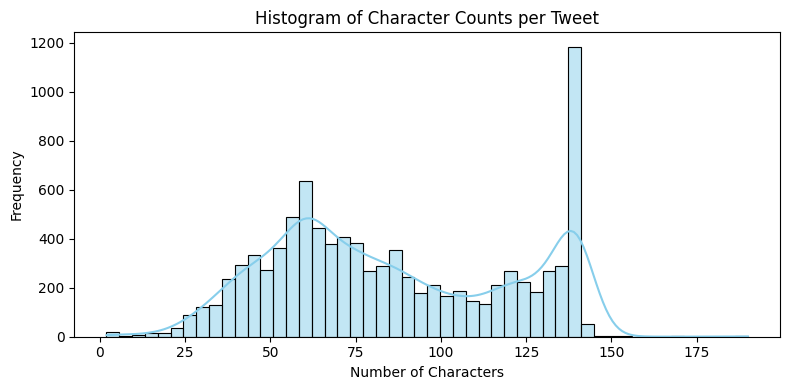

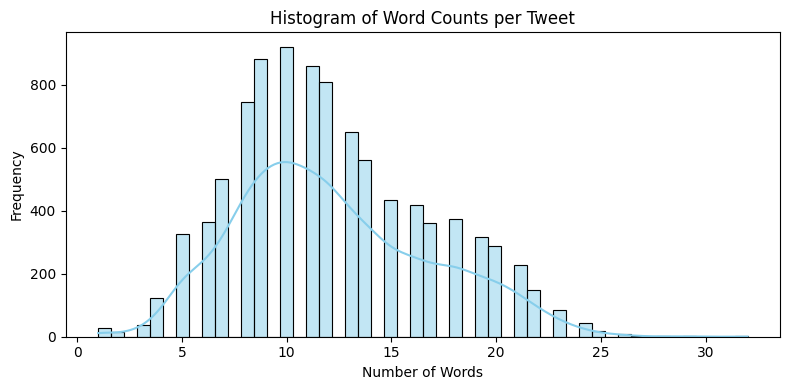

In [17]:
# Histogram of character lengths
plt.figure(figsize=(8, 4))
sns.histplot(df_train_copy['char_count'], bins=50, kde=True, color='skyblue')
plt.title("Histogram of Character Counts per Tweet")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Histogram of word lengths
plt.figure(figsize=(8, 4))
sns.histplot(df_train_copy['word_count'], bins=50, kde=True, color='skyblue')
plt.title("Histogram of Word Counts per Tweet")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Most tweets contain between 50 and 150 characters and around 8 to 15 words, with a noticeable spike at 140 characters likely due to Twitter’s former character limit.

/var/folders/vb/r_cbg99j0dj7dml3jnpfyl9h0000gn/T/ipykernel_4773/2008157681.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_copy, x='label', y='char_count', palette='pastel')


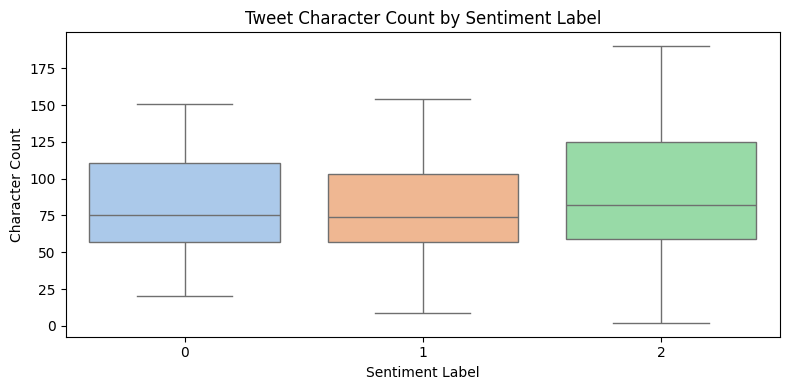

/var/folders/vb/r_cbg99j0dj7dml3jnpfyl9h0000gn/T/ipykernel_4773/2008157681.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train_copy, x='label', y='word_count', palette='pastel')


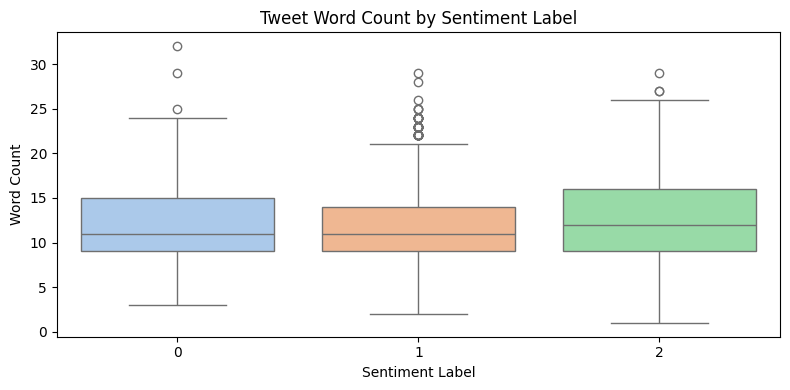

In [18]:
# Character count per label
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_train_copy, x='label', y='char_count', palette='pastel')
plt.title("Tweet Character Count by Sentiment Label")
plt.xlabel("Sentiment Label")
plt.ylabel("Character Count")
plt.tight_layout()
plt.show()

# Word count per label
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_train_copy, x='label', y='word_count', palette='pastel')
plt.title("Tweet Word Count by Sentiment Label")
plt.xlabel("Sentiment Label")
plt.ylabel("Word Count")
plt.tight_layout()
plt.show()

It seems majority of the tweets for each label share very close medians for both character count and word count.

### Average Unique Words per Label

In [19]:
from collections import defaultdict

In [20]:
def avg_unique_words_per_label(df, text_column='text', label_column='label'):
    """
    Returns a dictionary of average unique word counts per sentence for each label.
    """
    # from collections import defaultdict

    result = {}
    for label in sorted(df[label_column].unique()):
        subset = df[df[label_column] == label][text_column]
        unique_counts = [len(set(sentence.lower().split())) for sentence in subset]
        avg_unique = sum(unique_counts) / len(unique_counts) if unique_counts else 0
        result[label] = round(avg_unique, 2)

    return result

In [21]:
avg_uniques = avg_unique_words_per_label(df_train_copy, text_column='text', label_column='label')

for label, avg in avg_uniques.items():
    print(f"{label_names[label]} tweets: average of {avg} unique words per tweet")

Bearish tweets: average of 11.75 unique words per tweet
Bullish tweets: average of 11.65 unique words per tweet
Neutral tweets: average of 12.01 unique words per tweet


 Conclusion: Tweets across all sentiment classes seem to be similarly diverse in terms of word usage. So this feature is not likely to be discriminative.

### 2.3. - Extract and Count Tickers

In [22]:
def extract_valid_tickers(text):
    """
    Extracts cashtags like $AAPL, but filters out numeric values like $315.
    Keeps only all-uppercase alphabetic codes.
    """
    matches = re.findall(r'\$[A-Za-z]{1,5}', text)  
    return [m.upper() for m in matches]


all_valid_tickers = df_train['text'].apply(extract_valid_tickers)

# Flatten list
flat_valid_tickers = [t for sublist in all_valid_tickers for t in sublist]

# Count frequency
from collections import Counter
valid_ticker_counts = Counter(flat_valid_tickers)

# Total and unique
print(f"Total valid ticker mentions: {len(flat_valid_tickers)}")
print(f"Unique tickers (companies): {len(set(flat_valid_tickers))}")


Total valid ticker mentions: 2027
Unique tickers (companies): 1213


In [23]:
valid_ticker_counts.most_common(10)

[('$SPY', 26),
 ('$COMDX', 23),
 ('$TSLA', 20),
 ('$SCANX', 16),
 ('$SUMRX', 13),
 ('$NVDA', 12),
 ('$USO', 12),
 ('$MDCO', 11),
 ('$ECONX', 11),
 ('$AAPL', 10)]

We found 2,027 valid stock ticker mentions across the tweets, covering 1,213 unique companies. The most frequently mentioned tickers include popular stocks like $SPY,$COMDX,$TSLA

### 2.3. - Unigrams, Bigrams and Trigrams

In [24]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ricardo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
def plot_top_ngrams(corpus, ngram_range=(1,1), top_n=20, title="Top N-grams"):
    """
    Plot top N n-grams from a text corpus.
    """
    # Vectorize using CountVectorizer
    vec = CountVectorizer(stop_words='english', ngram_range=ngram_range)
    X = vec.fit_transform(corpus)
    
    # Sum up the counts of each n-gram
    sum_words = X.sum(axis=0)
    word_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)[:top_n]
    
    # Plot
    words, freqs = zip(*word_freq)
    plt.figure(figsize=(10, 4))
    sns.barplot(x=list(freqs), y=list(words))
    plt.title(title)
    plt.xlabel("Frequency")
    plt.tight_layout()
    plt.show()

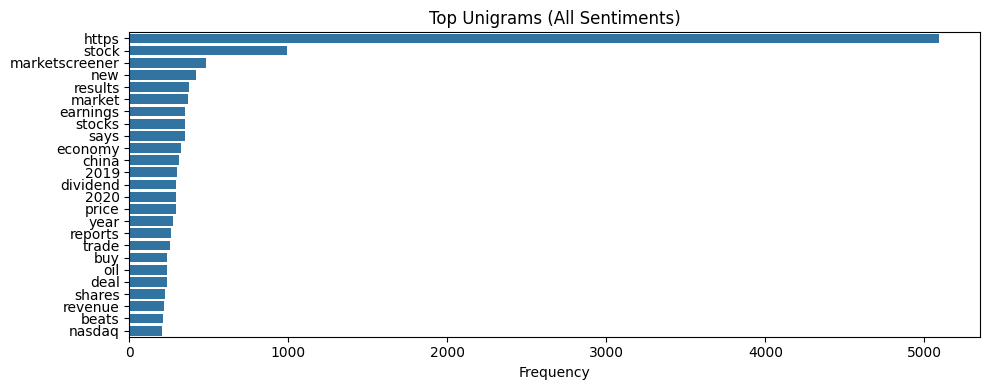

In [26]:
plot_top_ngrams(df_train_copy['text'], ngram_range=(1,1), top_n=25, title="Top Unigrams (All Sentiments)")

The most frequent unigrams are dominated by domain-specific terms like stock, market, and earnings, but also include frequent tokens like https and marketscreener, likely due to repeated links or sources.

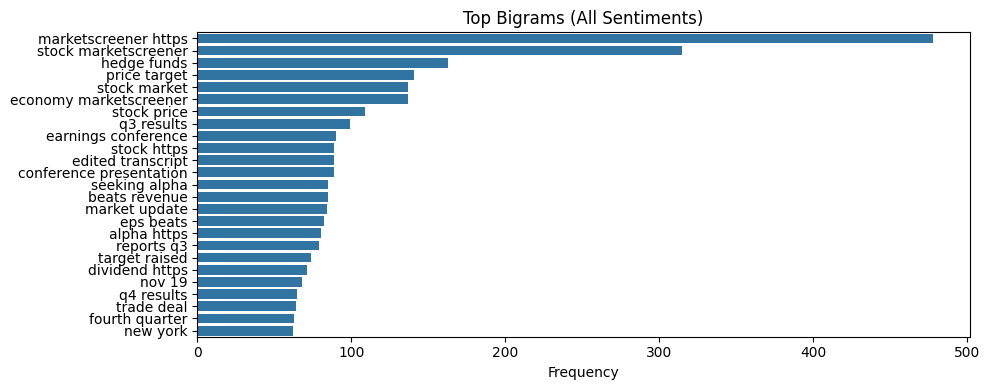

In [27]:
plot_top_ngrams(df_train_copy['text'], ngram_range=(2,2), top_n=25, title="Top Bigrams (All Sentiments)")

The most common bigrams reflect financial topics and sources, such as market screener, stock market, and hedge funds, with several combinations including links like marketscreener https.

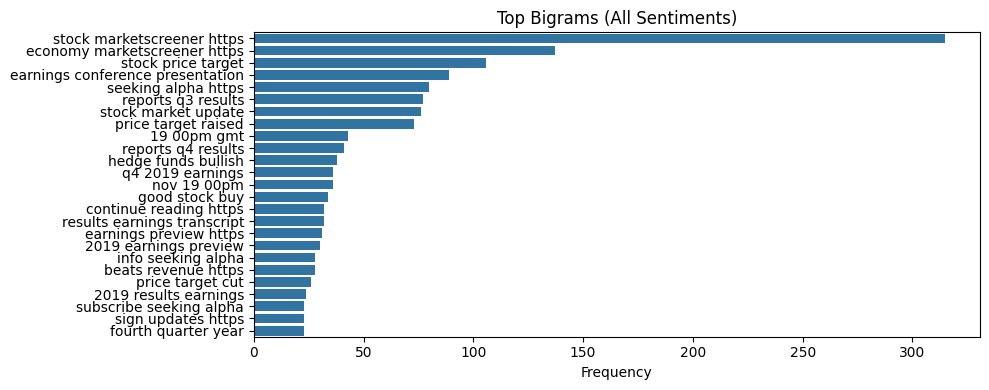

In [28]:
plot_top_ngrams(df_train_copy['text'], ngram_range=(3,3), top_n=25, title="Top Bigrams (All Sentiments)")

The most frequent bigrams highlight repeated financial phrases and reporting patterns, such as stock price target, earnings conference presentation, and hedge funds bullish, along with many combinations that include links or financial news sources.

### 2.3.1 - Top unigrams/bigrams/trigrams – Bearish Tweets

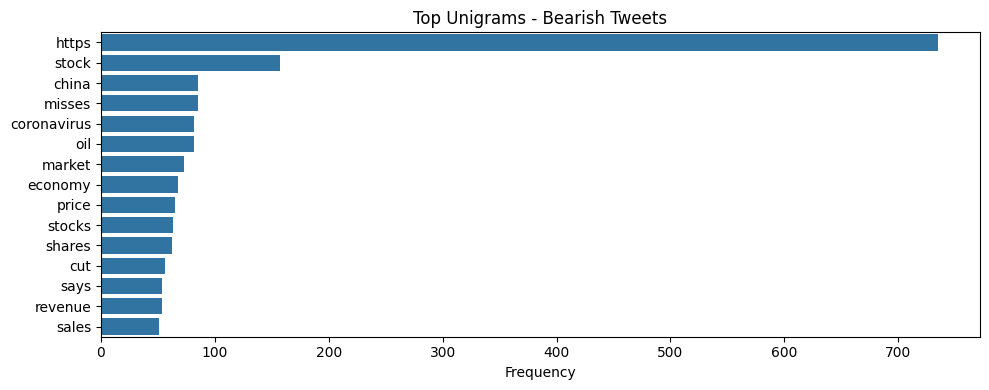

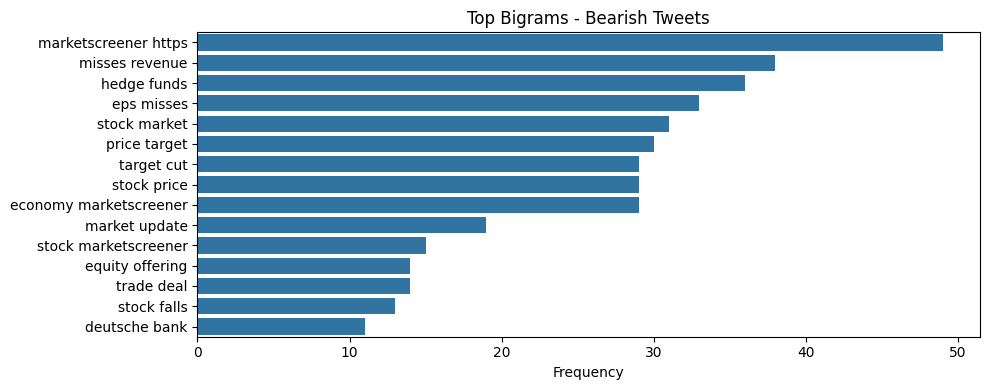

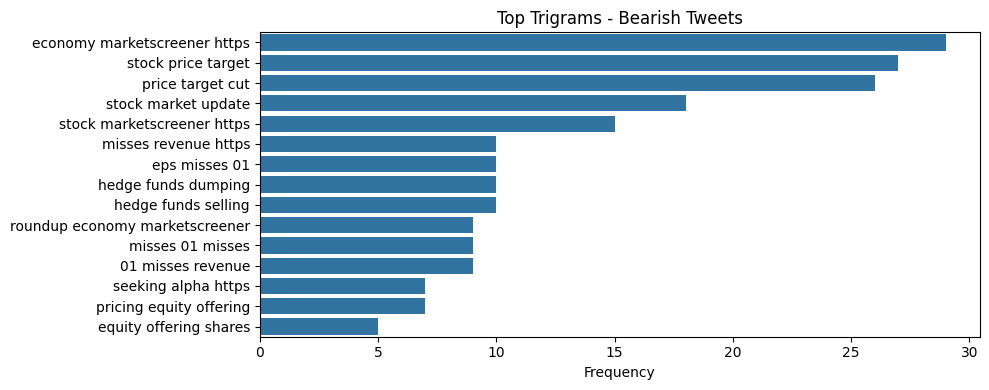

In [29]:
plot_top_ngrams(df_train_copy[df_train_copy['label'] == 0]['text'], ngram_range=(1,1), top_n=15, title="Top Unigrams - Bearish Tweets")
plot_top_ngrams(df_train_copy[df_train_copy['label'] == 0]['text'], ngram_range=(2,2), top_n=15, title="Top Bigrams - Bearish Tweets")
plot_top_ngrams(df_train_copy[df_train_copy['label'] == 0]['text'], ngram_range=(3,3), top_n=15, title="Top Trigrams - Bearish Tweets")

In bearish tweets, the most frequent unigrams, bigrams, and trigrams reflect concerns about financial underperformance and market instability, with terms like misses, cut, and coronavirus, expressions such as misses revenue and target cut, and longer phrases like price target cut and hedge funds dumping, often linked to external financial sources.

### 2.3.2 - Top unigrams/bigrams/trigrams – Bullish Tweets

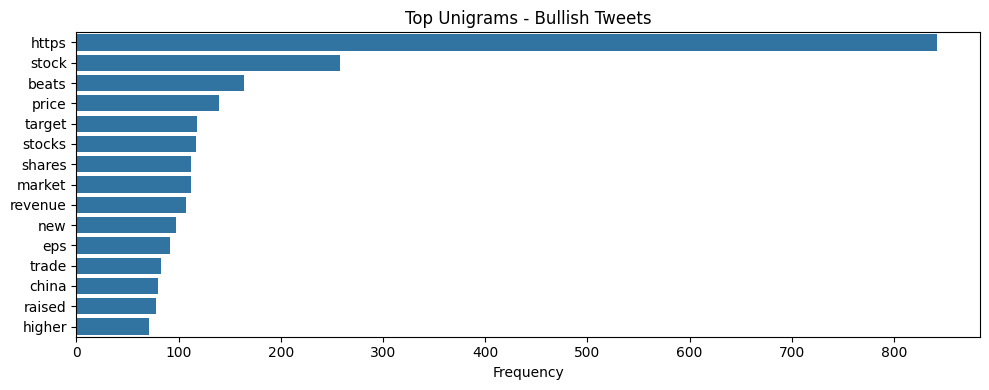

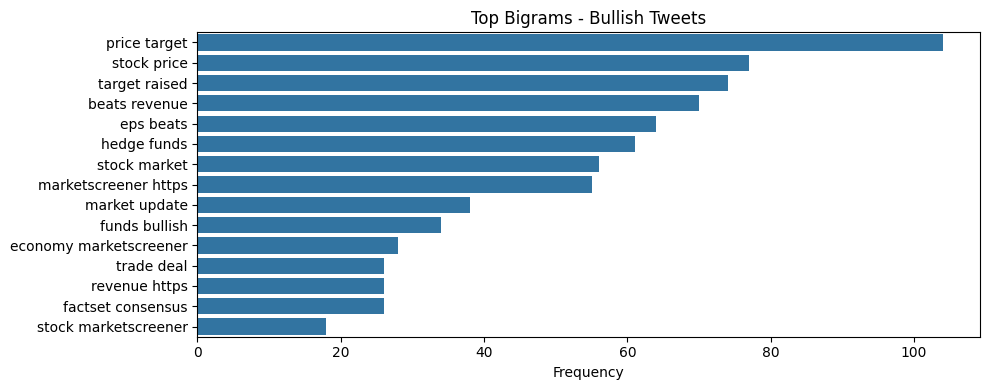

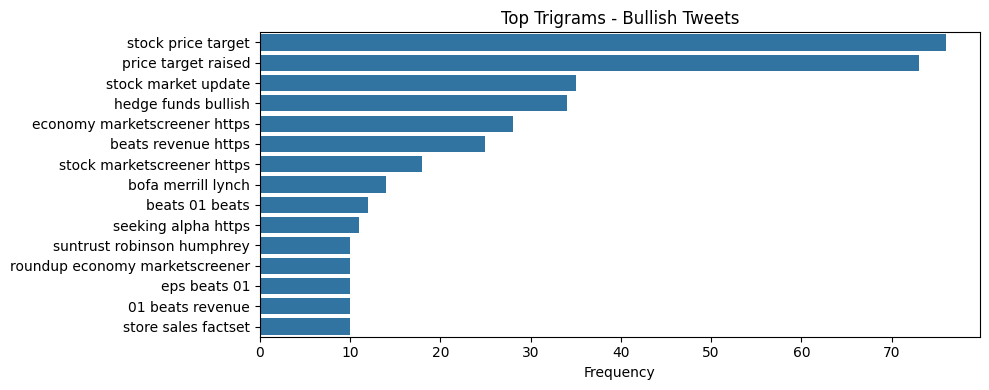

In [30]:
plot_top_ngrams(df_train_copy[df_train_copy['label'] == 1]['text'], ngram_range=(1,1), top_n=15, title="Top Unigrams - Bullish Tweets")
plot_top_ngrams(df_train_copy[df_train_copy['label'] == 1]['text'], ngram_range=(2,2), top_n=15, title="Top Bigrams - Bullish Tweets")
plot_top_ngrams(df_train_copy[df_train_copy['label'] == 1]['text'], ngram_range=(3,3), top_n=15, title="Top Trigrams - Bullish Tweets")

In bullish tweets, the most frequent terms and phrases highlight positive financial signals, with words like beats, raised, and higher, common bigrams such as price target and eps beats, and trigrams like stock price target and price target raised, all suggesting optimism and upward market sentiment.

### 2.3.3 - Top unigrams/bigrams/trigrams – Neutral Tweets

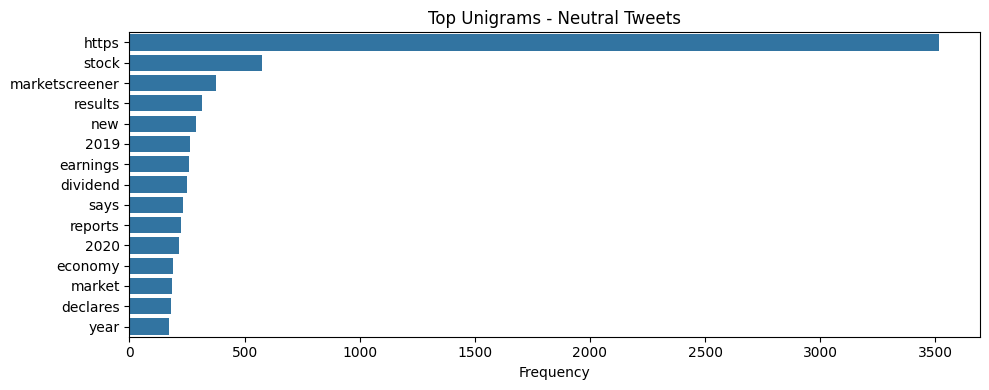

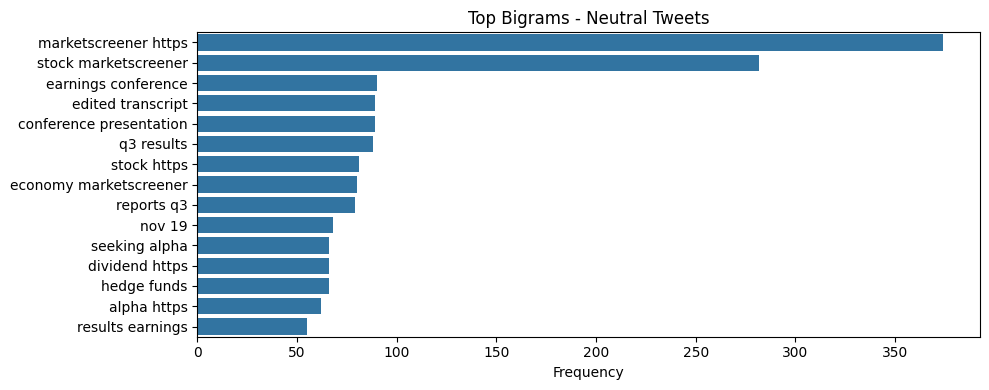

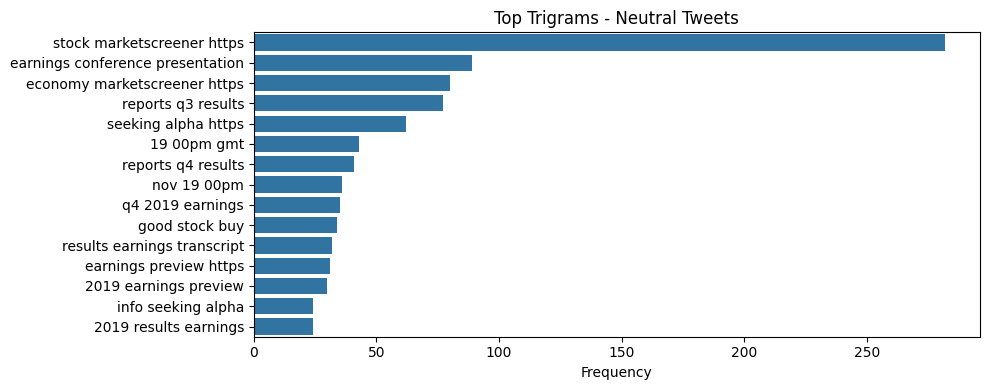

In [31]:
plot_top_ngrams(df_train_copy[df_train_copy['label'] == 2]['text'], ngram_range=(1,1), top_n=15, title="Top Unigrams - Neutral Tweets")
plot_top_ngrams(df_train_copy[df_train_copy['label'] == 2]['text'], ngram_range=(2,2), top_n=15, title="Top Bigrams - Neutral Tweets")
plot_top_ngrams(df_train_copy[df_train_copy['label'] == 2]['text'], ngram_range=(3,3), top_n=15, title="Top Trigrams - Neutral Tweets")

Neutral tweets are dominated by factual and financial reporting language, with frequent mentions of stock, results, and dividend, bigrams like earnings conference and edited transcript, and trigrams such as stock marketscreener https and earnings conference presentation that reflect an objective tone and informational focus.

### 2.4. - Stopwords

In [32]:
def extract_stopwords(text, stop_words):
    # Clean: lowercase, remove non-word characters
    text = re.sub(r"[^a-zA-Z\s]", "", text.lower())
    words = text.split()
    return [word for word in words if word in stop_words]

In [33]:
# Flatten list of stopwords across all tweets
all_stopwords = df_train_copy['text'].apply(lambda x: extract_stopwords(x, stop_words))
flat_stopwords = [word for sublist in all_stopwords for word in sublist]

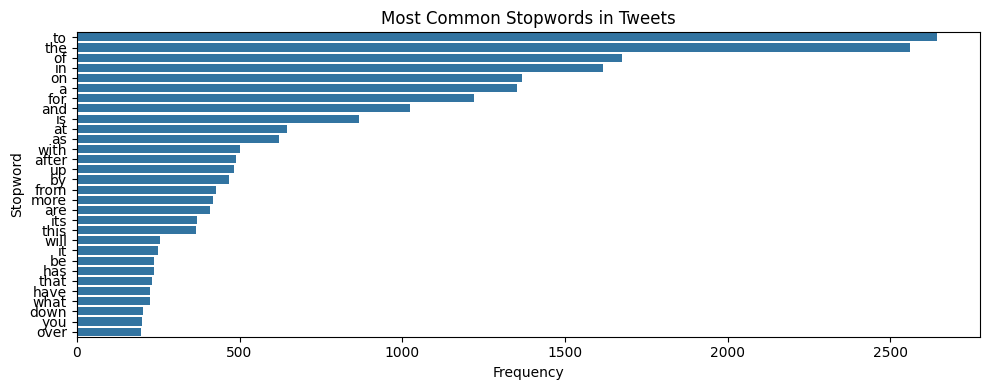

In [34]:
# Count frequency
stopword_counts = Counter(flat_stopwords).most_common(30)
words, freqs = zip(*stopword_counts)

# Plot
plt.figure(figsize=(10, 4))
sns.barplot(x=list(freqs), y=list(words))
plt.title("Most Common Stopwords in Tweets")
plt.xlabel("Frequency")
plt.ylabel("Stopword")
plt.tight_layout()
plt.show()

In [35]:
stopword_counts

[('to', 2643),
 ('the', 2559),
 ('of', 1675),
 ('in', 1616),
 ('on', 1367),
 ('a', 1353),
 ('for', 1221),
 ('and', 1024),
 ('is', 868),
 ('at', 646),
 ('as', 620),
 ('with', 501),
 ('after', 490),
 ('up', 482),
 ('by', 469),
 ('from', 429),
 ('more', 418),
 ('are', 408),
 ('its', 368),
 ('this', 365),
 ('will', 257),
 ('it', 250),
 ('be', 238),
 ('has', 238),
 ('that', 231),
 ('have', 226),
 ('what', 224),
 ('down', 204),
 ('you', 201),
 ('over', 198)]

As expected, common stopwords like to, the, of, and in appear most frequently in the dataset, reflecting their typical high occurrence in natural language and reinforcing the need for stopword removal during preprocessing.

### 2.5. - Noise detection (URLs, Emojis, etc.)

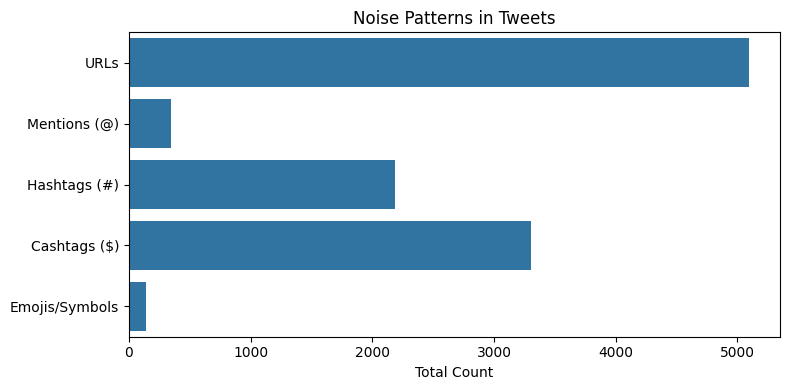

In [36]:
# Functions to count patterns
def count_pattern(text, pattern):
    return len(re.findall(pattern, text))

def count_all_emojis(text):
    # ASCII emoticon pattern (e.g., :) :-D ;P)
    emoticon_pattern = r'[:;=8][\-~]?[)\](DdpP]'

    # Count ASCII emoticons
    emoticon_count = len(re.findall(emoticon_pattern, text))

    # Count Unicode emojis (modern emojis)
    emoji_count = sum(1 for char in text if char in emoji.EMOJI_DATA)

    return emoticon_count + emoji_count

# Apply to each tweet
df_train_copy['url_count'] = df_train_copy['text'].apply(lambda x: count_pattern(x, r"http\S+|www\.\S+"))
df_train_copy['mention_count'] = df_train_copy['text'].apply(lambda x: count_pattern(x, r"@\w+"))
df_train_copy['hashtag_count'] = df_train_copy['text'].apply(lambda x: count_pattern(x, r"#\w+"))
df_train_copy['cashtag_count'] = df_train_copy['text'].apply(lambda x: count_pattern(x, r"\$\w+"))
df_train_copy['total_emoji_count'] = df_train_copy['text'].apply(count_all_emojis)


# Total counts
noise_counts = {
    'URLs': df_train_copy['url_count'].sum(),
    'Mentions (@)': df_train_copy['mention_count'].sum(),
    'Hashtags (#)': df_train_copy['hashtag_count'].sum(),
    'Cashtags ($)': df_train_copy['cashtag_count'].sum(),
    'Emojis/Symbols': df_train_copy['total_emoji_count'].sum(),
}

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(x=list(noise_counts.values()), y=list(noise_counts.keys()))
plt.title("Noise Patterns in Tweets")
plt.xlabel("Total Count")
plt.tight_layout()
plt.show()

In [37]:
noise_counts

{'URLs': 5095,
 'Mentions (@)': 347,
 'Hashtags (#)': 2182,
 'Cashtags ($)': 3305,
 'Emojis/Symbols': 137}

URLs and cashtags are the most common noise elements in the tweets, followed by hashtags, while mentions and emojis appear less frequently, highlighting the importance of cleaning these patterns during preprocessing.

### 2.5.1 - Hashtags

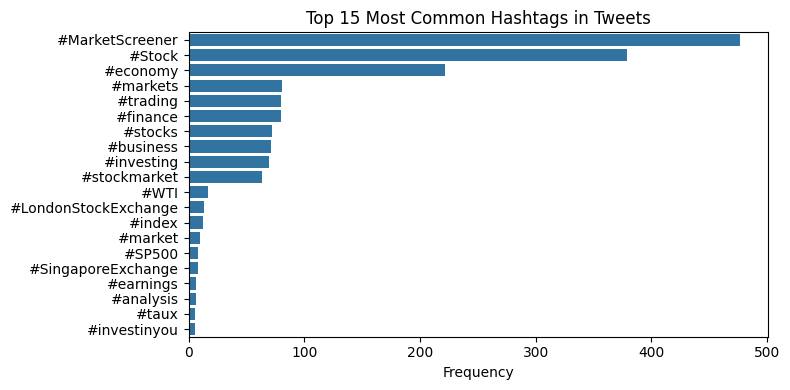

In [38]:
def get_hashtags(text):
    return re.findall(r'#\w+', text)

all_hashtags = df_train['text'].apply(get_hashtags)
flat_hashtags = [tag for sublist in all_hashtags for tag in sublist]
top_hashtags = Counter(flat_hashtags).most_common(20)

# Plot
labels, counts = zip(*top_hashtags)
plt.figure(figsize=(8, 4))
sns.barplot(x=list(counts), y=list(labels))
plt.title("Top 15 Most Common Hashtags in Tweets")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()


The most frequent hashtags in the dataset are heavily finance-related, with #MarketScreener, #Stock, and #economy leading the list, as expected due to the dataset’s strong focus on market news and investment discussions.

### 2.5.2 - Cashtags

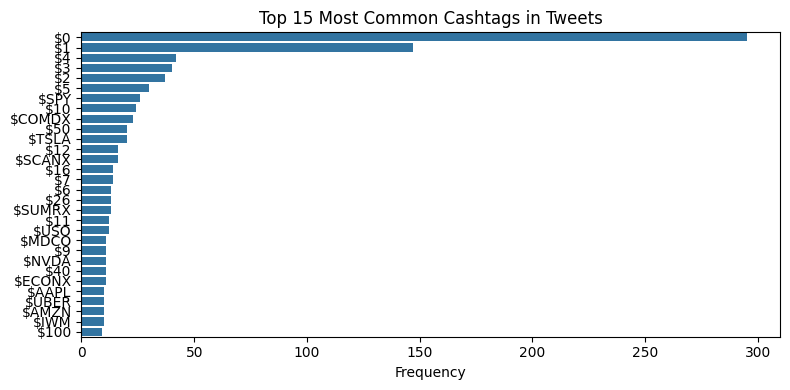

In [39]:
def get_cashtags(text):
    return re.findall(r'\$\w+', text)

all_cashtags = df_train_copy['text'].apply(get_cashtags)
flat_cashtags = [tag for sublist in all_cashtags for tag in sublist]
top_cashtags = Counter(flat_cashtags).most_common(30)

# Plot
labels, counts = zip(*top_cashtags)
plt.figure(figsize=(8, 4))
sns.barplot(x=list(counts), y=list(labels))
plt.title("Top 15 Most Common Cashtags in Tweets")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()


In [40]:
# Function to search for specific cashtags in the dataset
def find_cashtag_examples(df, cashtags, n_examples=2):
    """
    Find examples of tweets that contain specific cashtags
    
    Parameters:
    df (DataFrame): The dataframe to search in
    cashtags (list): List of cashtags to search for
    n_examples (int): Number of examples to return for each cashtag
    
    Returns:
    dict: Dictionary with cashtags as keys and lists of example tweets as values
    """
    examples = {}
    
    for tag in cashtags:
        # Find tweets containing this cashtag
        matches = df[df['text'].str.contains(tag, regex=False)]
        
        # Get n examples or all if less than n
        n = min(n_examples, len(matches))
        if n > 0:
            examples[tag] = matches['text'].iloc[:n].tolist()
        else:
            examples[tag] = ["No examples found"]
    
    return examples

# Search for examples of tweets with specific cashtags
cashtags_to_find = ['$0', '$1', '$2', '$3', '$4', '$5']
examples = find_cashtag_examples(df_train, cashtags_to_find, n_examples=3)

# Display the examples
for tag, tweets in examples.items():
    print(f"\n{tag} Examples:")
    for i, tweet in enumerate(tweets):
        print(f"{i+1}. {tweet}")


$0 Examples:
1. Agati Fund : NTA Estimate - $0.1975 #AgatiFund #Stock #MarketScreener https://t.co/3FKyrRUzCE https://t.co/6Zu7vETcrU
2. Vanguard Dividend Appreciation ETF declares quarterly distribution of $0.5985
3. $AEL: American Equity Investment Life increases annual cash dividend to $0.30/share from $0.28/share https://t.co/xXAcIhgee4

$1 Examples:
1. Arch Coal stock price target cut to $97 from $100 at B. Riley FBR
2. Aurora Cannabis stock price target cut to C$1.00 from C$1.75 at Stifel Nicolaus
3. Bluebird bio stock price target cut to $86 from $172 at Evercore ISI

$2 Examples:
1. Funko stock price target cut to $10 from $25 at Stifel Nicolaus
2. Home Depot stock price target cut to $237 from $240 at Instinet
3. L Brands stock price target cut to $16 from $20 at Wedbush

$3 Examples:
1. AMC Networks price target cut to $35 from $39 at Imperial Capital
2. GM stock price target cut to $30 from $32 at Deutsche Bank
3. Helmerich & Payne started at sell with $34 stock price targe

### 2.5.3 - Emojis/Symbols

findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
/var/folders/vb/r_cbg99j0dj7dml3jnpfyl9h0000gn/T/ipykernel_4773/2180957632.py:17: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
findfont: Font family 'Segoe UI Emoji' not found.
findfont: Font family 'Segoe UI Emoji' not found.
/var/folders/vb/r_cbg99j0dj7dml3jnpfyl9h0000gn/T/ipykernel_4773/2180957632.py:17: UserWarning: Glyph 128200 (\

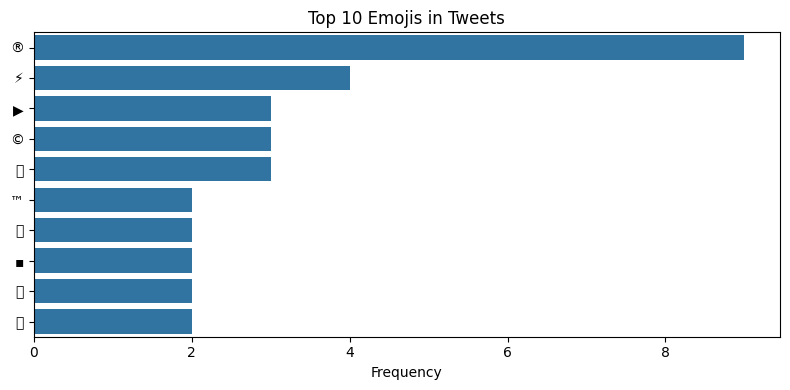

In [41]:
def get_emojis(text):
    return [char for char in text if char in emoji.EMOJI_DATA]

df_train_copy['emojis'] = df_train_copy['text'].apply(get_emojis)
flat_emojis = [e for sublist in df_train_copy['emojis'] for e in sublist]
top_emojis = Counter(flat_emojis).most_common(10)

# Apply font
plt.rcParams['font.family'] = 'Segoe UI Emoji'

# Plot
labels, counts = zip(*top_emojis)
plt.figure(figsize=(8, 4))
sns.barplot(x=list(counts), y=list(labels))
plt.title("Top 10 Emojis in Tweets")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

In [42]:
len(flat_emojis)

60

Emoji usage in the dataset is relatively low, suggesting that emojis play a minimal role in the overall tweet content.

### 2.5.4 - Summary statistics 

To better understand the overall structure and style of the tweets in our dataset, we compute a set of descriptive statistics. These include basic counts (total sentences, total words), lexical diversity (unique tokens), and stylistic features common in informal or emotional expression such as emoticons, elongated words, repeated punctuation, and capitalization.

In [43]:
def dataset_stats(df, text_column='text'):
    texts = df[text_column].dropna()

    total_tweets = texts.shape[0]
    total_words = texts.apply(lambda x: len(x.split())).sum()
    avg_words_per_tweet = total_words / total_tweets
    unique_tokens = set(word for tweet in texts for word in tweet.split())
    total_unique_tokens = len(unique_tokens)

    # Emoticons (text-based)
    emoticons_pattern = r'[:;=8][\-~]?[)\](DdpP]'
    total_emoticons = texts.str.count(emoticons_pattern).sum()

    # Elongated words
    elongated_pattern = r'(.)\1{2,}'
    total_elongated = texts.str.count(elongated_pattern).sum()

    # Repeated punctuation
    total_multi_excl = texts.str.count(r'!{2,}').sum()
    total_multi_q = texts.str.count(r'\?{2,}').sum()
    total_multi_stop = texts.str.count(r'\.{2,}').sum()

    # All uppercase words (longer than 1 letter)
    total_all_caps = texts.apply(lambda x: sum(1 for word in x.split() if word.isupper() and len(word) > 1)).sum()

    return pd.Series({
        'Total Sentences': total_tweets,
        'Total Words': total_words,
        'Average Words/Sentence': round(avg_words_per_tweet, 2),
        'Total Unique Tokens': total_unique_tokens,
        'Total Emoticons': total_emoticons,
        'Total Elongated Words': total_elongated,
        'Total Multi Exclamation Marks': total_multi_excl,
        'Total Multi Question Marks': total_multi_q,
        'Total Multi Stop Marks': total_multi_stop,
        'Total All Capitalized Words': total_all_caps
    })

In [44]:
stats = dataset_stats(df_train_copy, text_column='text')
print(stats)

Total Sentences                    9543.00
Total Words                      116218.00
Average Words/Sentence               12.18
Total Unique Tokens               31609.00
Total Emoticons                      77.00
Total Elongated Words               439.00
Total Multi Exclamation Marks        23.00
Total Multi Question Marks            3.00
Total Multi Stop Marks              247.00
Total All Capitalized Words        7871.00
dtype: float64


### 2.5.5 Language Detection

In [ ]:
def detect_language_with_langdetect(line): 
    from langdetect import detect_langs
    try: 
        langs = detect_langs(line) 
        for item in langs: 
            return item.lang, item.prob 
    except: return "err", 0.0  
df_train_copy[['lang_code', 'lang_prob']] = pd.DataFrame(df_train_copy['text'].apply(detect_language_with_langdetect).tolist(),index=df_train_copy.index)
print(df_train_copy['lang_code'].value_counts()) 
print(df_train_copy['lang_code'].value_counts(normalize=True)*100) 
languages = ['de', 'ca', 'fr', 'es', 'sv']

samples_list = []

for lang in languages:
    # Get all tweets for this language
    lang_tweets = df_train_copy[df_train_copy['lang_code'] == lang]
    n = min(20, len(lang_tweets))
    sample = lang_tweets.sample(n=n, random_state=42)
    samples_list.append(sample)

sampled_tweets = pd.concat(samples_list, axis=0).reset_index(drop=True)

sampled_tweets[['lang_code', 'text']]

lang_code
en    8869
ca     111
de     107
es      83
fr      81
      ... 
cy       1
sk       1
ja       1
sw       1
sq       1
Name: count, Length: 31, dtype: int64
lang_code
en    92.937231
ca     1.163156
de     1.121241
es     0.869747
fr     0.848790
        ...    
cy     0.010479
sk     0.010479
ja     0.010479
sw     0.010479
sq     0.010479
Name: proportion, Length: 31, dtype: float64


,lang_code,text
0,de,$BIIB 😀 https://t.co/j5gwpGJVu1
1,de,ATSG Launches New Website https://t.co/Jnonz0ecWt https://t.co/dAi0UQ2ZEY
2,de,N.Y. FED'S 42-DAY REPO OP. OVERSUBSCRIBED; $49.05B OF BIDS
3,de,SBFGP
4,de,"Hedge Funds Are Selling Greif, Inc. (GEF)"
...,...,...
95,sv,"$SP500 - The Bubble: Bigger, Fatter, Uglier. https://t.co/XSkbRhLMmg #stocks #stockmarket #finance"
96,sv,Skanska AB reports Q4 results
97,sv,Norsk Hydro declares NOK1.25 dividend
98,sv,6 Guru Stocks Expanding Earnings
